In [1]:
import os
import toml
import multiprocessing as mp
from functools import reduce, partial

import pandas as pd
import scipy
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from pandas.plotting import lag_plot, autocorrelation_plot, bootstrap_plot, radviz

import copy
import gc

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.decomposition import PCA
from sklearn import preprocessing

from typing import List, Dict, NoReturn, Any, Callable, Union, Optional

from preproc import import_csv, new_hybrid_interpolator
from customobjs import objdict

In [2]:
import sys
sys.path

['/home/gml/Proyects/Personal/Diabetes-Analysis',
 '/usr/lib/python38.zip',
 '/usr/lib/python3.8',
 '/usr/lib/python3.8/lib-dynload',
 '',
 '/home/gml/.cache/pypoetry/virtualenvs/diabetes-analysis-N70SBYxr-py3.8/lib/python3.8/site-packages',
 '/home/gml/.cache/pypoetry/virtualenvs/diabetes-analysis-N70SBYxr-py3.8/lib/python3.8/site-packages/IPython/extensions',
 '/home/gml/.ipython']

In [3]:
def dist_plot(series: pd.core.series.Series, dropna: bool = True, sig: Optional[int] = None) -> NoReturn:
    """
        Given a pandas Series, generate a descriptive visualisation 
        with a boxplot and a histogram with a kde.
        By default, this function drops `nan` values. If you desire to
        handle them differently, you should do so beforehand and/or
        specify dropna=False.
    """
    
    if dropna:
        series = series.dropna()
    sig = sig or 0
    
    
    quarts = scipy.stats.mstats.mquantiles(series, [0.001, 0.25, 0.5, 0.75, 0.975])
    
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.25, .75)})
    sns.boxplot(series, ax=ax_box)
    sns.stripplot(series, color="orange", jitter=0.2, size=2.5, ax=ax_box)
    sns.distplot(series, ax=ax_hist, kde=True)
    ax_hist.axvline(series.mean())
    ax_hist.set_xticks(quarts)
    #ax_box.set(xlabel=f'Mean value : {int(series.mean())}')
    plt.title(f"Glycaemic Distribution μ = {round(series.mean(), sig)}, σ = {round(series.std(), sig)}")
##

def comparative_hba1c_plot(
    df: pd.core.frame.DataFrame,
    colum_name: str = "Sensor Glucose (mg/dL)",
    hba1c: Callable = lambda x: (x + 105) / 36.5,
    windows: Dict[str,int] = {
        "weekly": 7,
        "monthly": 30
    },
    kind: str = "mean"
) -> NoReturn:
    """ 
    """
    
    glc_to_hba1c = lambda x: (x + 105) / 36.5
    hba1c_to_glc = lambda x: x*36.5 - 105 
    valid_kinds = ["mean", "std", "var", "median"]
    
    if kind in valid_kinds:
        df.groupby(df.index.date)[colum_name].\
            apply(eval(f"pd.Series.{kind}")).apply(hba1c).\
                plot(**{"label":"daily"})
                
        for key, value in windows.items():
            ax = df.groupby(df.index.date)[colum_name].\
                    apply(eval(f"pd.Series.{kind}")).rolling(value).mean().\
                            apply(hba1c).plot(**{"label":key})
    
        ax.set_ylabel("HbA1c %")
        mean_hba1c = glc_to_hba1c(eval(f"df[colum_name].{kind}()"))
        secax = ax.secondary_yaxis('right', functions=(hba1c_to_glc, glc_to_hba1c))
        secax.set_ylabel('mg/dL')
        plt.axhline(mean_hba1c, **{"label": f"mean = {round(mean_hba1c,1)}", "c": "blue"})
        plt.legend()
        plt.title(f"Average {kind} of {colum_name}")
    else:
        raise Exception(f"kind should be one of {valid_kinds}")
##

def proportions_visualiser(
    df: pd.core.frame.DataFrame,
    colum_name: str = "Sensor Glucose (mg/dL)",
    limits: Dict[str,int] = {
        "low": 70,
        "high": 180
    },
    windows: Dict[str,int] = {
        "weekly": 7,
        "monthly": 30
    },
    kind: str = "TIR"
) -> NoReturn:
    """
        Wuhuuuu
    """
    
    valid_kinds = ["TIR", "TBR", "TAR"]
    titles = {
        "TIR": f"Time In Range [{limits['low']},{limits['high']})",
        "TAR": f"Time Above Range >= {limits['high']}",
        "TBR": f"Time Below Range < {limits['low']}"
    }
    
    kind = kind.upper()
    
    if kind not in valid_kinds:
        raise Exception(f"Invalid kind `{kind}`, select one from {valid_kinds}")
    
    TIR = lambda y: 100 * y[ (y >= limits["low"]) & (y < limits["high"]) ].count() / y.count()
    TBR = lambda y: 100 * y[ (y < limits["low"]) ].count() / y.count()
    TAR = lambda y: 100 * y[ (y >= limits["high"]) ].count() / y.count()
    
    _proportions = df["Sensor Glucose (mg/dL)"].groupby(data.index.date).apply(eval(f"{kind}"))
    
    _proportions.plot(**{"label": "daily"})
    
    for key, value in windows.items():
        _ax = _proportions.rolling(value).mean().plot(**{"label":key})
    
    _mean_proportion = _proportions.mean()
    plt.ylabel("Percentage")
    plt.axhline(_mean_proportion, **{"label": f"mean = {round(_mean_proportion,1)}", "c": "blue"})
    plt.legend()
    plt.title(titles[kind])
##    

def nonull_indices(
    df: pd.DataFrame,
    column: str
) -> pd.core.indexes.datetimes.DatetimeIndex:
    """
    """  
    _nonull = df[column].dropna()
    _nonull = _nonull[ _nonull > 0 ]
    return _nonull.index
##

def bolus_indices(
    df: pd.DataFrame, 
    columns: Optional[List[str]] = None
) -> pd.core.indexes.datetimes.DatetimeIndex:
    """
    """
    
    columns = columns or ["BWZ Correction Estimate (U)",  "BWZ Carb Input (grams)"]
    _nonull = partial(nonull_indices, df)
    indices_ls = list(map(_nonull, columns))
    return reduce(lambda x, y: x.union(y), indices_ls)
##


def basal_only(df: pd.DataFrame, column: str = "Sensor Glucose (mg/dL)") -> pd.DataFrame:
    """
    """
    basal = df.copy()
    for uid in bolus_indices(basal):
        real = uid+dt.timedelta(hours=2, minutes=30)
        closest = df.index[df.index.searchsorted(real) - 1]  # Otherwise it goes out of bounds !
        basal.loc[uid:closest, column] = np.nan
    return basal
##

def hourly_trends(df: pd.DataFrame, kind: str = "mean", deltas: Optional[List[int]] = None) -> NoReturn:
    """
    """
    valid_kinds = ["mean", "std", "var", "median"]
    deltas = deltas or [15, 30, 60, 120]
    
    if kind in valid_kinds:
        figs = [
            df.groupby(df.index.hour)[f'd{i}']\
                .apply(eval(f"np.{kind}"))\
                    .plot(label=f"{i} ") 
            for i in deltas
        ]
        figs[-1].legend()
        plt.title(f"Hourly trends : {kind}")
        plt.xticks([i for i in range(24)])
        plt.ylabel("mg/dl")
    else:
        raise Exception(f"Invalid kind, select one from {valid_kinds}")
##        

In [4]:
def hourly_trends(df: pd.DataFrame, kind: str = "mean", deltas: Optional[List[int]] = None) -> NoReturn:
    """
    """
    valid_kinds = ["mean", "std", "var", "median"]
    deltas = deltas or [15, 30, 60, 120]
    
    if kind in valid_kinds:
        figs = [
            df.groupby(df.index.hour)[f'd{i}']\
                .apply(eval(f"np.{kind}"))\
                    .plot(label=f"{i} ") 
            for i in deltas
        ]
        figs[-1].legend()
        plt.title(f"Hourly trends : {kind}")
        plt.xticks([i for i in range(24)])
        plt.ylabel("mg/dl")
    else:
        raise Exception(f"Invalid kind, select one from {valid_kinds}")
##   

In [5]:
def compute_time_periodicity(df: pd.DataFrame) -> NoReturn:
    """
    """
    # Coulmns to capture daily periodicity :
    T = 1439
    min_res_t_series = pd.Series(df.index.hour*60 + df.index.minute)
    _tmp = pd.DataFrame({
        'hour': df.index.hour,
        'minute': min_res_t_series,
        'x(t)': min_res_t_series.apply(lambda x: np.cos(2*np.pi*x / T)),
        'y(t)': min_res_t_series.apply(lambda x: np.sin(2*np.pi*x / T))
    })
    _tmp.index = df.index
    return _tmp
##

In [6]:
%matplotlib inline
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (15, 8)

In [8]:
!pwd

/home/gml/Proyects/Personal/Diabetes-Analysis


In [9]:
!ls interpolated/ | grep 13

NG1988812H_Maganna_Gustavo_(til:20-05-06)_(from:20-02-13)_interpolated.csv
NG1988812H_Maganna_Gustavo_(til:20-05-26)_(from:20-05-13)_interpolated.csv
NG1988812H_Maganna_Gustavo_(til:20-06-04)_(from:20-03-13)_interpolated.csv
NG1988812H_Maganna_Gustavo_(til:20-06-09)_(from:20-05-13)_interpolated.csv
NG1988812H_Maganna_Gustavo_(til:20-10-13)_(from:20-09-14)_interpolated.csv


In [11]:
raw = import_csv("interpolated/NG1988812H_Maganna_Gustavo_(til:20-10-13)_(from:20-09-14)_interpolated.csv")

In [12]:
raw.columns

Index(['New Device Time', 'BG Reading (mg/dL)', 'Linked BG Meter ID',
       'Basal Rate (U/h)', 'Temp Basal Amount', 'Temp Basal Type',
       'Temp Basal Duration (h:mm:ss)', 'Bolus Type',
       'Bolus Volume Selected (U)', 'Bolus Volume Delivered (U)',
       'Bolus Duration (h:mm:ss)', 'Prime Type', 'Prime Volume Delivered (U)',
       'Alarm', 'Suspend', 'Rewind', 'BWZ Estimate (U)',
       'BWZ Target High BG (mg/dL)', 'BWZ Target Low BG (mg/dL)',
       'BWZ Carb Ratio (g/U)', 'BWZ Insulin Sensitivity (mg/dL/U)',
       'BWZ Carb Input (grams)', 'BWZ BG Input (mg/dL)',
       'BWZ Correction Estimate (U)', 'BWZ Food Estimate (U)',
       'BWZ Active Insulin (U)', 'BWZ Status', 'Sensor Calibration BG (mg/dL)',
       'Sensor Glucose (mg/dL)', 'ISIG Value', 'Event Marker', 'Bolus Number',
       'Bolus Cancellation Reason', 'BWZ Unabsorbed Insulin Total (U)',
       'Final Bolus Estimate', 'Scroll Step Size', 'Insulin Action Curve Time',
       'Sensor Calibration Rejected Reason

In [13]:
my_columns = [
    'BG Reading (mg/dL)', 'Basal Rate (U/h)', 'Temp Basal Amount', 
    'Temp Basal Type', 'Temp Basal Duration (h:mm:ss)', 'Bolus Volume Delivered (U)',
    'BWZ Active Insulin (U)', 'Sensor Calibration BG (mg/dL)', 'Sensor Glucose (mg/dL)', 
    'ISIG Value', 'hour', 'minute', 'x(t)', 'y(t)', 'Alarm', 'BWZ Carb Ratio (g/U)'
]
data = raw[my_columns]
deltas = [1, 5, 15, 30, 60, 120]
woo = pd.DataFrame()
for i in deltas:
    woo[f"Dg{i}"] = data["Sensor Glucose (mg/dL)"].diff(i)
    woo[f"D2g{i}"] = woo[f"Dg{i}"].diff(1)
data = data.join(woo)

In [14]:
data["BWZ Carb Ratio (g/U)"] = data["BWZ Carb Ratio (g/U)"].fillna(method="ffill")

In [15]:
data.columns

Index(['BG Reading (mg/dL)', 'Basal Rate (U/h)', 'Temp Basal Amount',
       'Temp Basal Type', 'Temp Basal Duration (h:mm:ss)',
       'Bolus Volume Delivered (U)', 'BWZ Active Insulin (U)',
       'Sensor Calibration BG (mg/dL)', 'Sensor Glucose (mg/dL)', 'ISIG Value',
       'hour', 'minute', 'x(t)', 'y(t)', 'Alarm', 'BWZ Carb Ratio (g/U)',
       'Dg1', 'D2g1', 'Dg5', 'D2g5', 'Dg15', 'D2g15', 'Dg30', 'D2g30', 'Dg60',
       'D2g60', 'Dg120', 'D2g120'],
      dtype='object')

In [16]:
def hourly_trends(df: pd.DataFrame, kind: str = "mean", deltas: Optional[List[int]] = None) -> NoReturn:
    """
    """
    valid_kinds = ["mean", "std", "var", "median"]
    deltas = deltas or [15, 30, 60, 120]
    
    if kind in valid_kinds:
        figs = [
            df.groupby(df.index.hour)[f'd{i}']\
                .apply(eval(f"np.{kind}"))\
                    .plot(label=f"{i} ") 
            for i in deltas
        ]
        figs[-1].legend()
        plt.title(f"Hourly trends : {kind}")
        plt.xticks([i for i in range(24)])
        plt.ylabel("mg/dl")
    else:
        raise Exception(f"Invalid kind, select one from {valid_kinds}")
##   

In [17]:
data["Sensor Glucose (mg/dL)"].dropna().shape, data.shape

((50466,), (53510, 28))

In [18]:
# sns.distplot(woo.d30)

In [19]:
print("start \t:", data.index[0])
print("end \t:", data.index[-1])

start 	: 2020-09-06 20:04:00
end 	: 2020-10-13 23:53:00


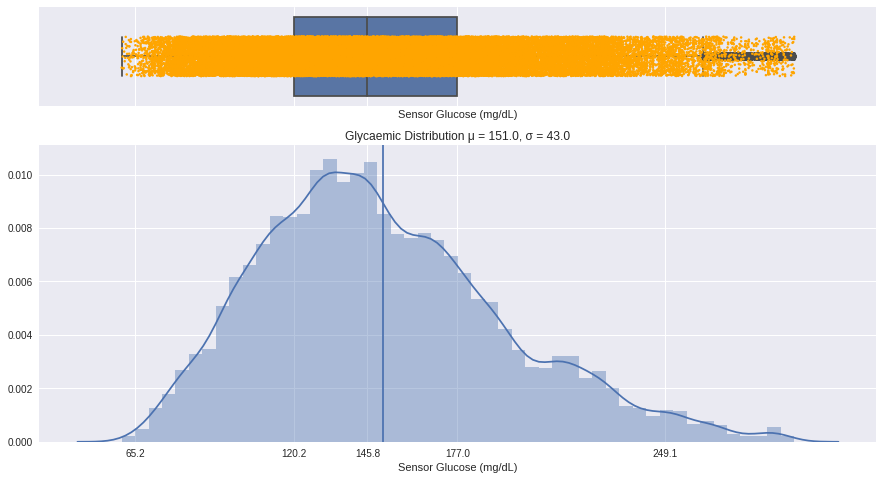

In [20]:
dist_plot(data["Sensor Glucose (mg/dL)"])

In [21]:
#bootstrap_plot(data["Sensor Glucose (mg/dL)"].dropna())

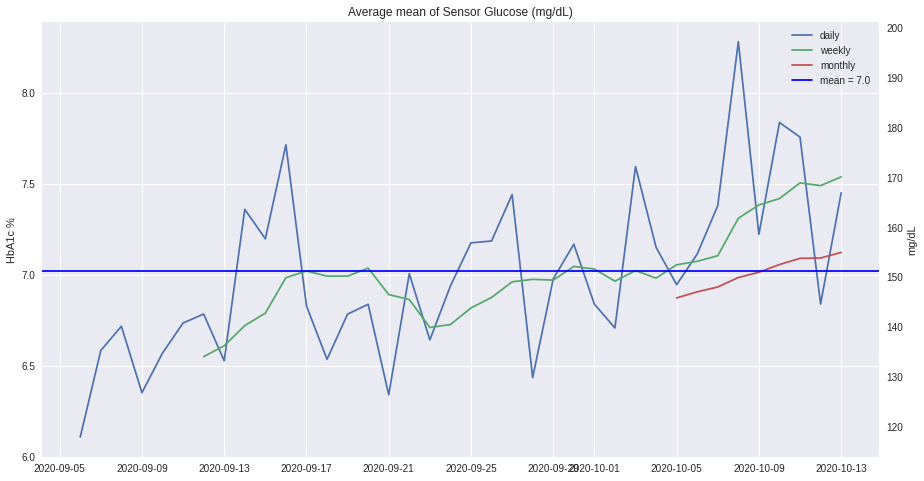

In [22]:
comparative_hba1c_plot(data, kind="mean")

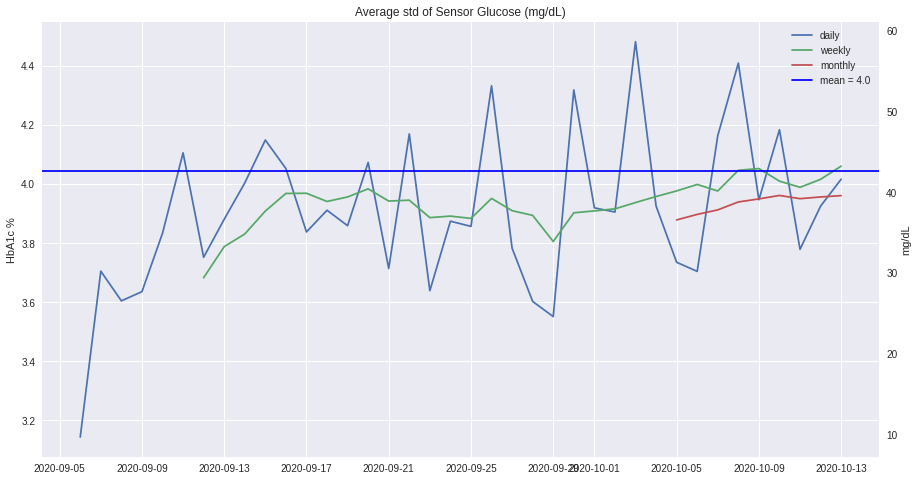

In [23]:
comparative_hba1c_plot(data, kind='std')

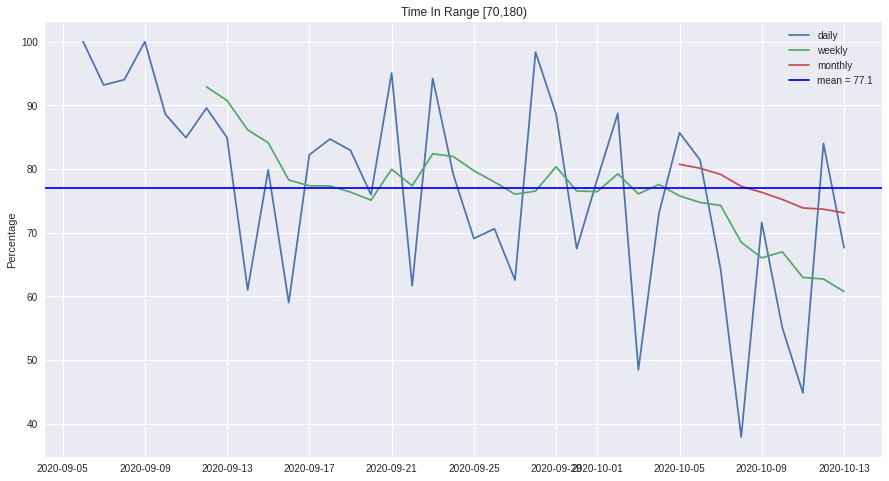

In [25]:
proportions_visualiser(data, kind="tir")

In [26]:
dates = pd.unique(data.index.date)
n_total = len(dates)
print(f"Number of days in data : {len(dates)}")

Number of days in data : 38


In [27]:
n_month = 15
n_latest = 3
#month = data.loc[dates[len(dates) - n_month]:dates[-1], :] if n_month < n_total else None
latest = data.loc[dates[len(dates)- n_latest]:dates[-1], :] if n_latest < n_total else None
lday = data.loc[dates[len(dates)- 1]:dates[-1], :] if n_latest < n_total else None

In [28]:
latest.columns

Index(['BG Reading (mg/dL)', 'Basal Rate (U/h)', 'Temp Basal Amount',
       'Temp Basal Type', 'Temp Basal Duration (h:mm:ss)',
       'Bolus Volume Delivered (U)', 'BWZ Active Insulin (U)',
       'Sensor Calibration BG (mg/dL)', 'Sensor Glucose (mg/dL)', 'ISIG Value',
       'hour', 'minute', 'x(t)', 'y(t)', 'Alarm', 'BWZ Carb Ratio (g/U)',
       'Dg1', 'D2g1', 'Dg5', 'D2g5', 'Dg15', 'D2g15', 'Dg30', 'D2g30', 'Dg60',
       'D2g60', 'Dg120', 'D2g120'],
      dtype='object')

In [29]:
#latest.groupby(latest.index.date).plot()

In [64]:
grouped = latest.groupby(latest.index.hour)[[
    "Dg30", "Dg60", "Dg120"
]]

mean = grouped.mean()
std = grouped.std() / len(grouped)**0.5

#mean.plot(xticks=range(24),figsize=(18,14))

In [66]:
#latest.plot(x="hour", y="Bolus Volume Delivered (U)", kind="scatter")
latest.columns

Index(['BG Reading (mg/dL)', 'Basal Rate (U/h)', 'Temp Basal Amount',
       'Temp Basal Type', 'Temp Basal Duration (h:mm:ss)',
       'Bolus Volume Delivered (U)', 'BWZ Active Insulin (U)',
       'Sensor Calibration BG (mg/dL)', 'Sensor Glucose (mg/dL)', 'ISIG Value',
       'hour', 'minute', 'x(t)', 'y(t)', 'Alarm', 'BWZ Carb Ratio (g/U)',
       'Dg1', 'D2g1', 'Dg5', 'D2g5', 'Dg15', 'D2g15', 'Dg30', 'D2g30', 'Dg60',
       'D2g60', 'Dg120', 'D2g120'],
      dtype='object')

In [67]:
latest["Inverse Ratio (U/g)"] = 1 / latest["BWZ Carb Ratio (g/U)"]

<ipython-input-67-880b4cdff83d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  latest["Inverse Ratio (U/g)"] = 1 / latest["BWZ Carb Ratio (g/U)"]


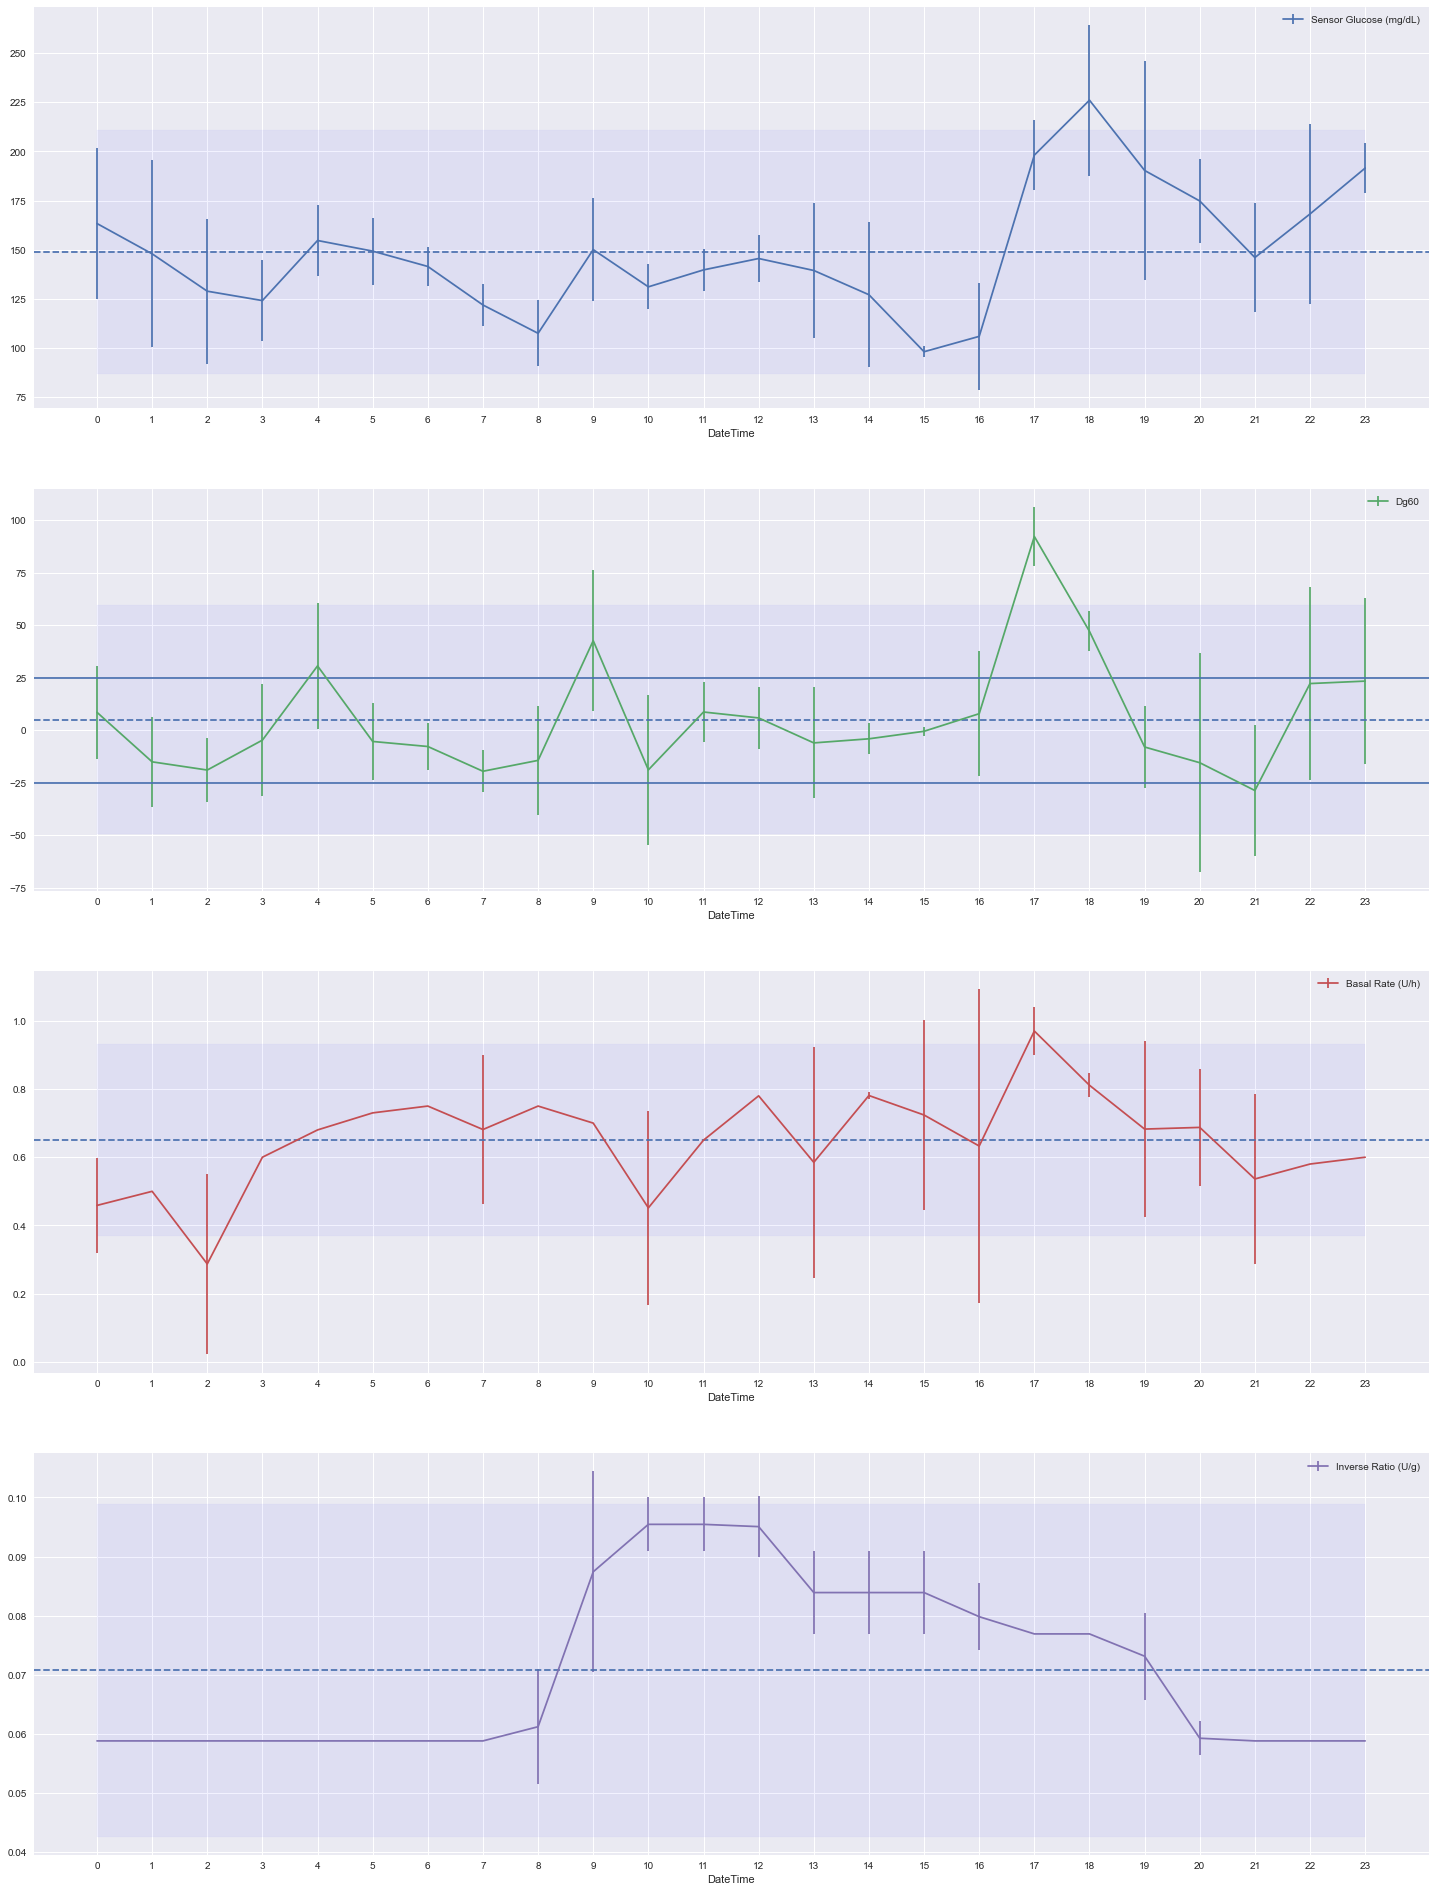

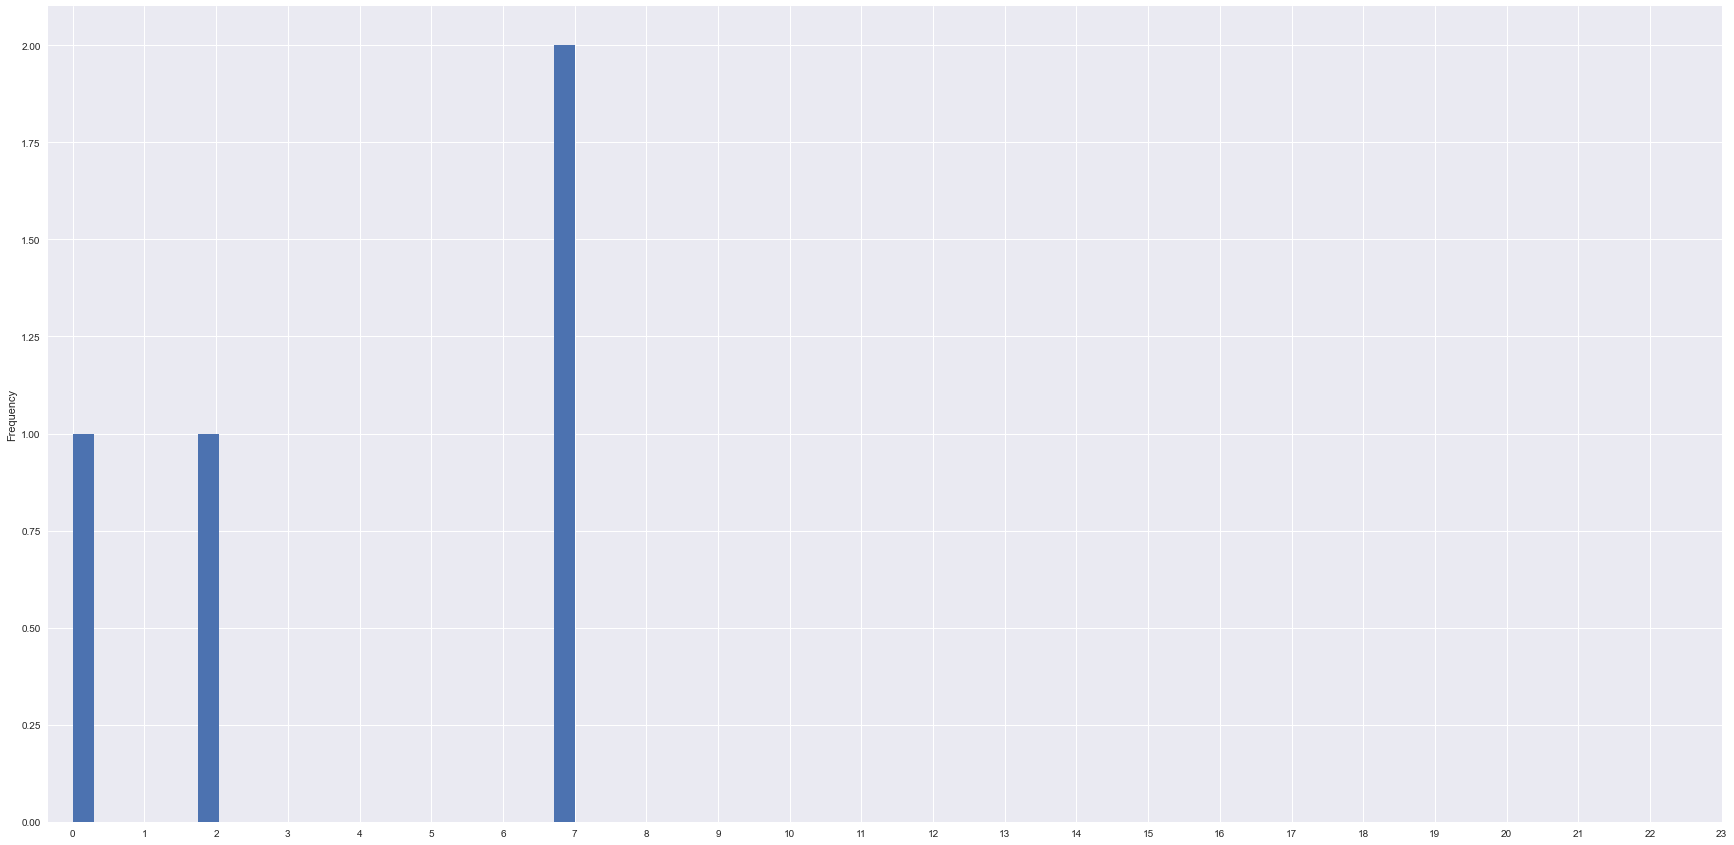

In [68]:
grouped = latest.groupby(latest.index.hour)[[
    "Sensor Glucose (mg/dL)", "Dg60", "Basal Rate (U/h)", "Inverse Ratio (U/g)"
]]

mean = grouped.mean()
std = grouped.std() 
sem = grouped.sem()

ax = mean.plot(
    yerr=std,
    xticks=range(24),
    subplots=True,
    figsize=(25,34),
    sharex=False
)

#ax[1].axhline()
for i, column in enumerate(mean):
    ma, mstd = mean[column].mean(), mean[column].std()
    ax[i].fill_between(range(24), ma - 2 * mstd, ma + 2 * mstd, color='b', alpha=0.05)
    ax[i].axhline(ma, linestyle="--")

# Add limits for differences :    
ax[1].axhline(-25)
ax[1].axhline(25)
plt.figure()
latest[ latest.Alarm == 'SUSPEND BEFORE LOW ALARM, QUIET' ].hour.plot(
    kind="hist", xticks=range(24), figsize=(30,15), bins=24
)


## Hypoglycaemia pattern detection

In [77]:
#keyword = 'SUSPEND BEFORE LOW'
keyword = 'LOW'
alarms  = []
for i in latest.Alarm.dropna().unique().tolist():
    if keyword in i:
        alarms.append(i)
alarms

['SUSPEND BEFORE LOW ALARM, QUIET',
 'PUMP ALARM LOW BATTERY',
 'ALERT BEFORE LOW',
 'PUMP ALARM LOW RESERVOIR',
 'ALERT ON LOW WHILE SUSPENDED',
 'SUSPEND BEFORE LOW ALARM, PATIENT UNRESPONSIVE, MEDICAL DEVICE EMERGENCY',
 'ALERT ON LOW']

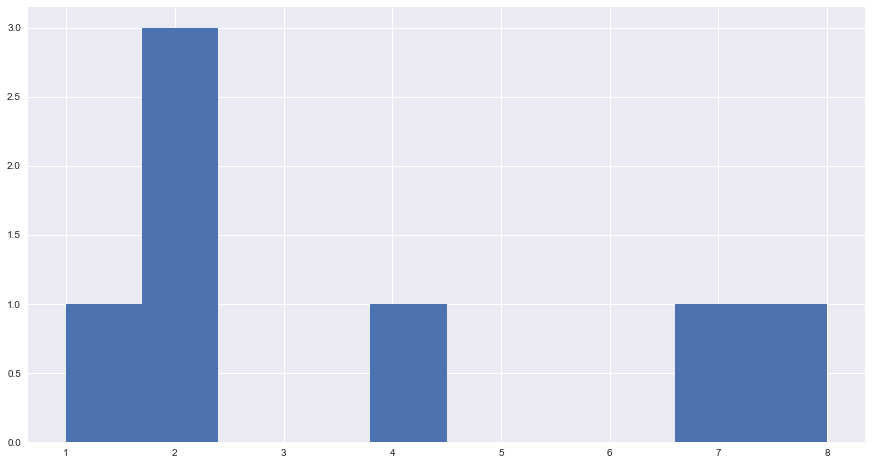

In [98]:
latest[ latest.Alarm == 'SUSPEND BEFORE LOW ALARM, QUIET' ].hour.hist()
#latest[ 'SUSPEND BEFORE LOW' in latest.Alarm ].hour.hist()


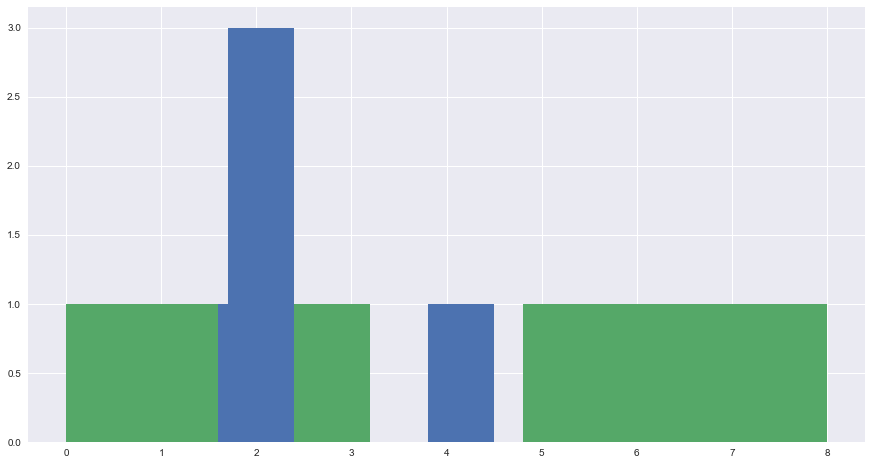

In [91]:
latest[ latest.Alarm == 'SUSPEND BEFORE LOW ALARM, QUIET' ].hour.hist()
latest[ (latest['Bolus Volume Delivered (U)'] > 0) & (latest.hour < 9)].hour.hist()

In [46]:
std.sem()

Sensor Glucose (mg/dL)    3.308583
Dg60                      1.906451
Basal Rate (U/h)          0.020134
dtype: float64

In [36]:
for i in mean:
    print(i)

Sensor Glucose (mg/dL)
Dg120
Basal Rate (U/h)


In [37]:
mean["Dg120"].mean()

-0.38838975564108935

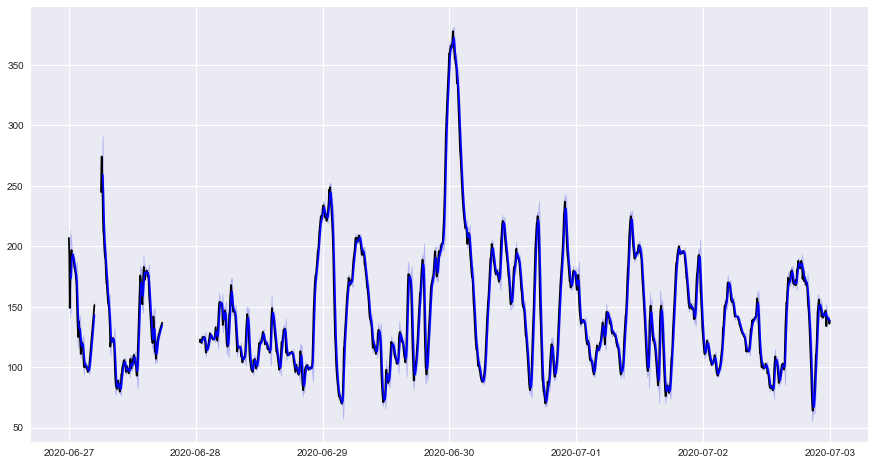

In [38]:
price = latest["Sensor Glucose (mg/dL)"]
ma = price.rolling(20).mean()
mstd = price.rolling(20).std()
plt.figure()
plt.plot(price.index, price, 'k')
plt.plot(ma.index, ma, 'b')
plt.fill_between(mstd.index, ma - 2 * mstd, ma + 2 * mstd, color='b', alpha=0.2)

Sensor Glucose (mg/dL)       AxesSubplot(0.125,0.125;0.227941x0.755)
Dg60                      AxesSubplot(0.398529,0.125;0.227941x0.755)
Basal Rate (U/h)          AxesSubplot(0.672059,0.125;0.227941x0.755)
dtype: object

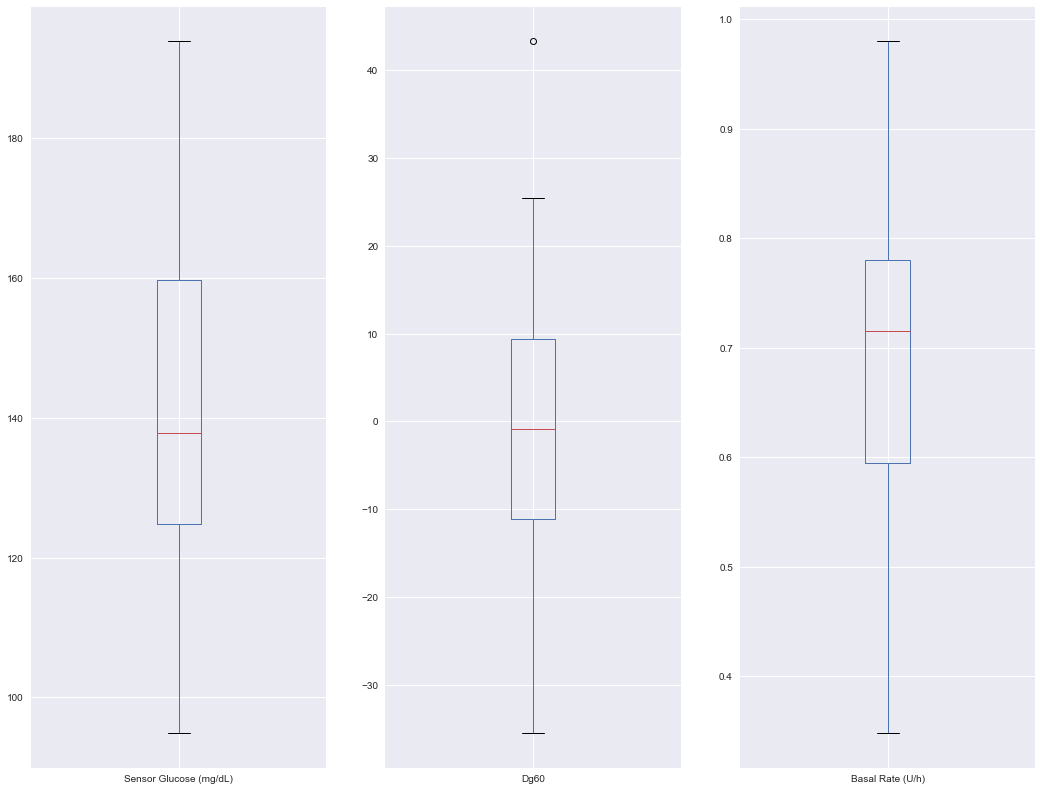

In [186]:
latest.groupby(latest.index.hour)[[
    "Sensor Glucose (mg/dL)", "Dg60", "Basal Rate (U/h)"
]].apply(pd.Series.mean).plot(
    kind="box",
    subplots=True,
    figsize=(18,14)
)

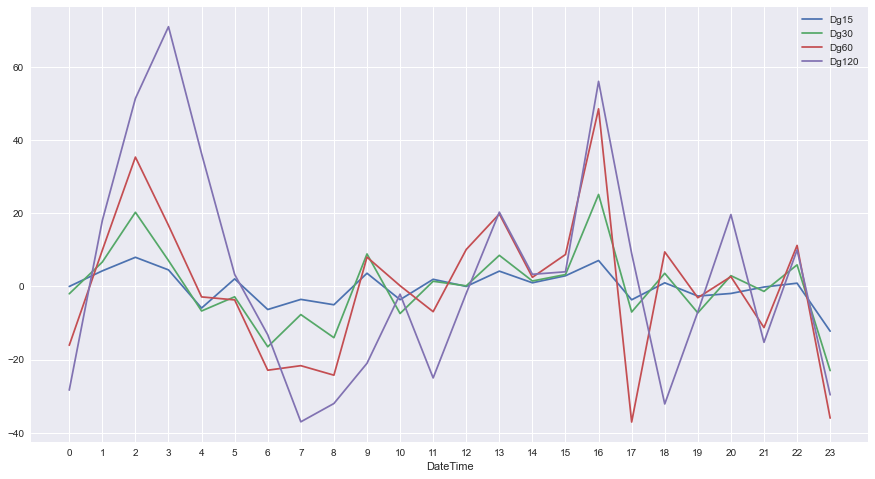

In [103]:
latest[["Dg15", "Dg30", "Dg60", "Dg120"]]\
    .groupby(latest.index.hour)\
        .apply(pd.Series.median)\
            .plot(xticks=range(24))

In [243]:
select = latest["Sensor Glucose (mg/dL)"].dropna()

In [249]:
plt.close("all")
#select.groupby(select.index.hour).plot(kind="box")

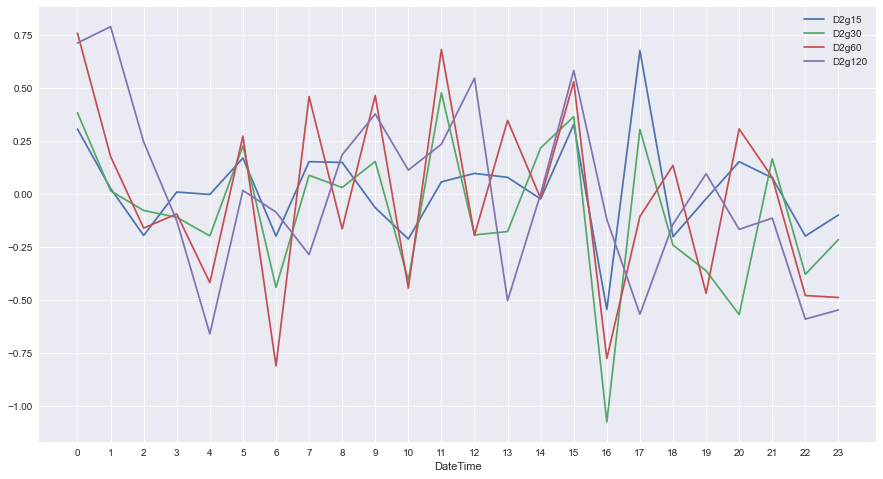

In [105]:
latest[["D2g15", "D2g30", "D2g60", "D2g120"]]\
    .groupby(latest.index.hour)\
        .apply(pd.Series.median)\
            .plot(xticks=range(24))

In [108]:
#latest["Sensor Glucose (mg/dL)"]
#help(pd.Series.autocorr)

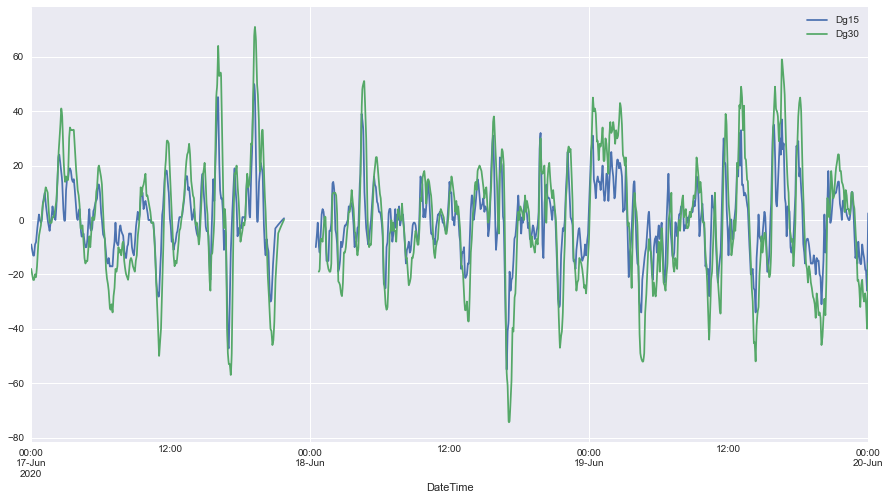

In [95]:
latest[["Dg15", "Dg30"]].groubpy.plot()

In [198]:
"""
sns.scatterplot(
    data=latest,
    x="minutes",
    y="Sensor Glucose (mg/dL)",
    hue=latest.index.date,
    size="d30"
)
"""

'\nsns.scatterplot(\n    data=latest,\n    x="minutes",\n    y="Sensor Glucose (mg/dL)",\n    hue=latest.index.date,\n    size="d30"\n)\n'

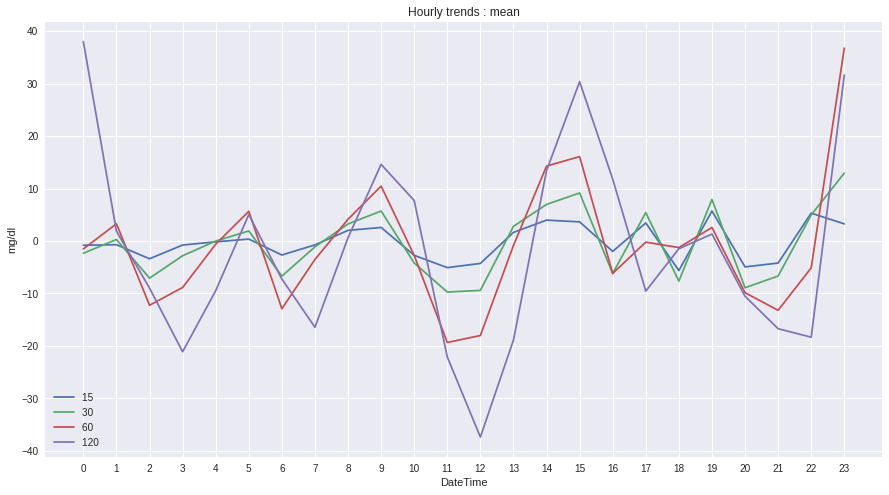

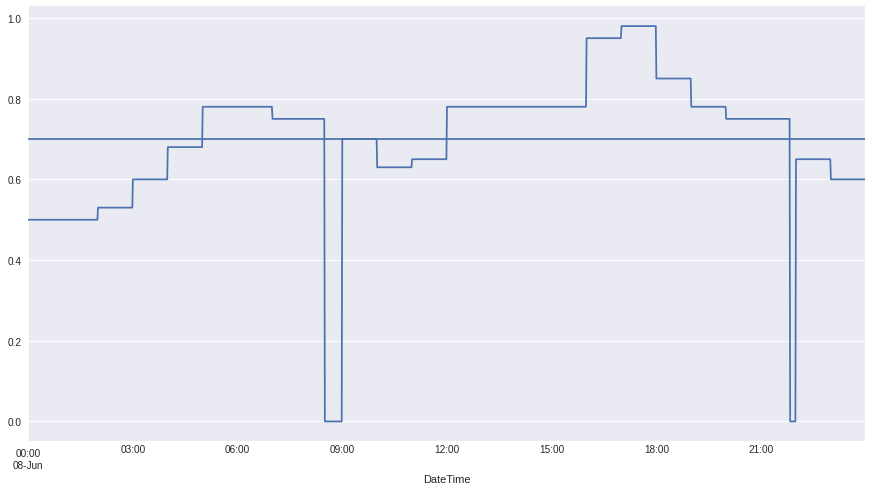

In [224]:
hourly_trends(latest, kind="mean")
plt.figure()
debasal = latest.loc[str(dates[-2]),"Basal Rate (U/h)"]
debasal.plot()
plt.axhline(debasal.mean())

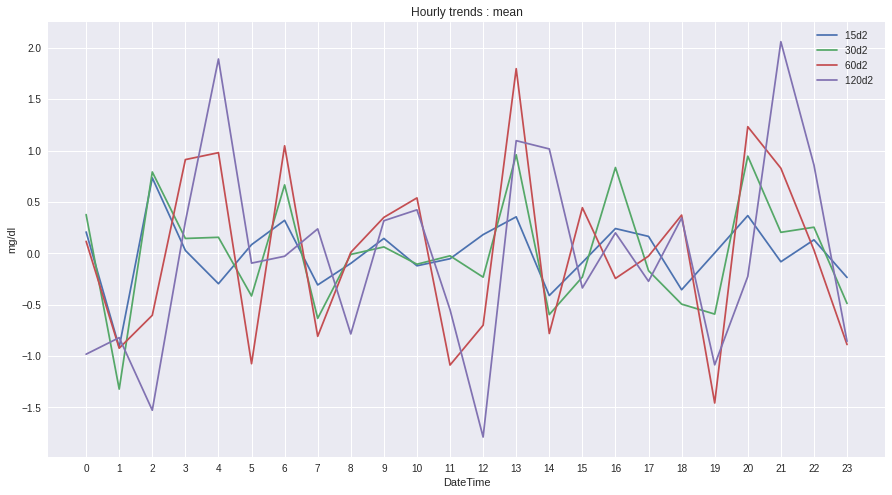

In [36]:
hourly_trends(latest, kind="mean", deltas=["15d2", "30d2", "60d2", "120d2"])

In [89]:
latest["Basal Rate (U/h)"].describe()

count    4321.000000
mean        0.710278
std         0.192548
min         0.000000
25%         0.630000
50%         0.750000
75%         0.780000
max         1.310000
Name: Basal Rate (U/h), dtype: float64

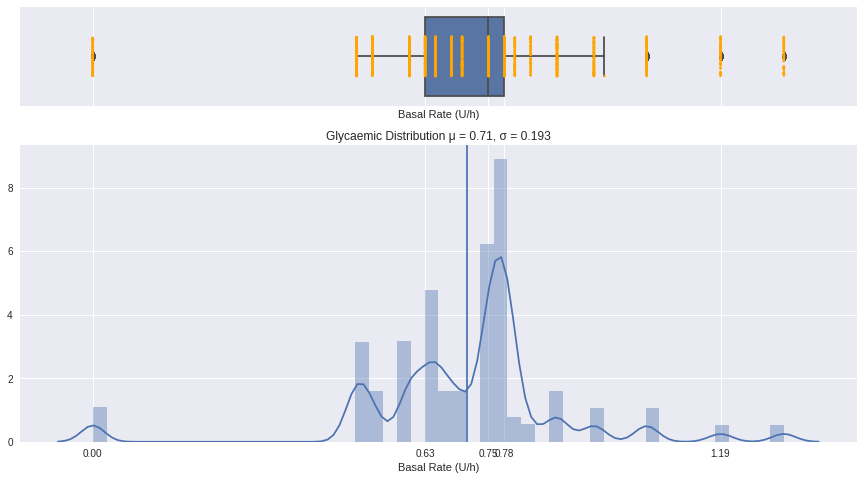

In [94]:
dist_plot(latest["Basal Rate (U/h)"], sig=3)

In [40]:
#hourly_trends(basal, kind="std")

In [79]:
basal = basal_only(latest)

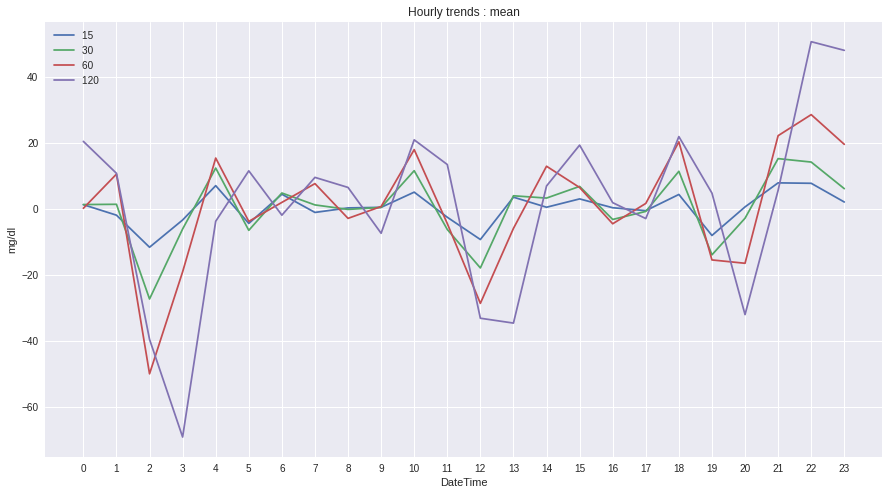

In [80]:
hourly_trends(basal)

In [81]:
#hourly_trends(basal, kind="std")

In [82]:
bar = nonull_indices(latest, "BWZ Carb Input (grams)")

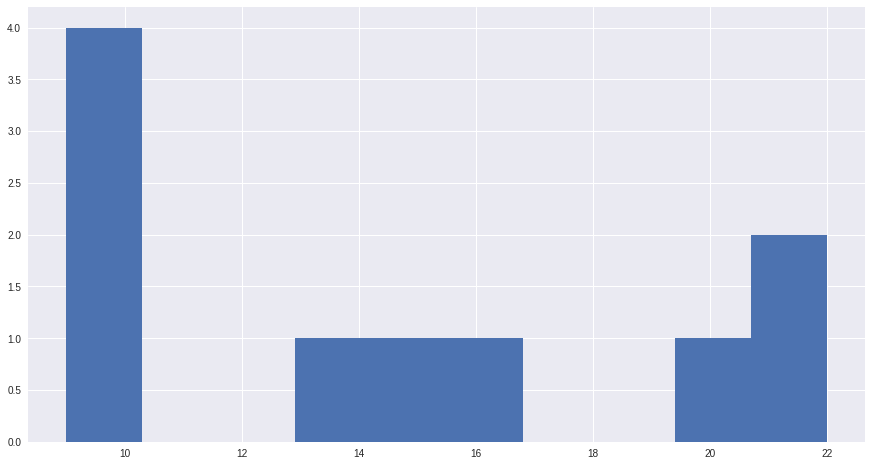

In [83]:
bar.hour.to_series().hist()

In [84]:
foo = nonull_indices(latest, "BWZ Correction Estimate (U)")

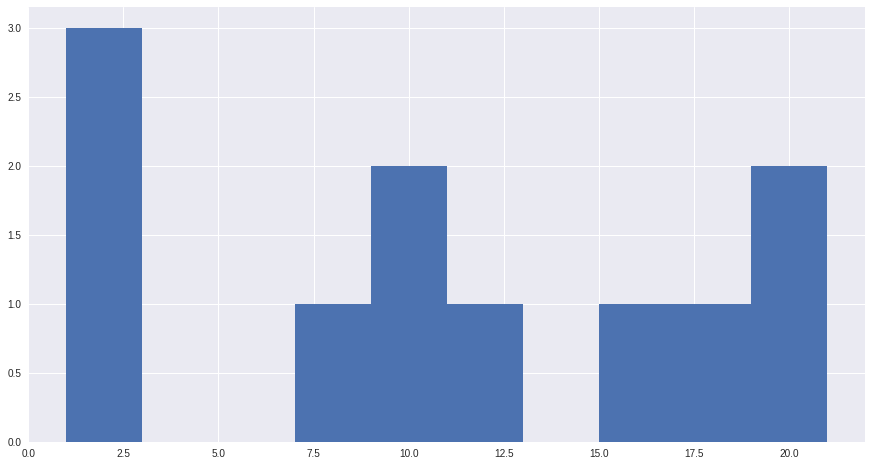

In [85]:
foo.hour.to_series().hist()